In [406]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [407]:
# Define the image transformation functions
def flip(image):
    # Flip the image horizontally
    return cv2.flip(image, 1)

def rotate(image):
    # Rotate the image by 30 degrees
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 30, 1)
    return cv2.warpAffine(image, M, (cols, rows))

In [408]:
def histogram_equalization(img):
    return cv2.equalizeHist(img)

In [409]:
def resize_image(img):
    return cv2.resize(img , (4*124 , 4*64))

In [410]:
def extract_hand_segment(image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range of skin color in HSV
    lower_skin = np.array([0, 50, 90], dtype=np.uint8)
    upper_skin = np.array([50, 255, 255], dtype=np.uint8)

    # Create a mask using the skin color range
    mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Dilate the mask to remove small holes in the object
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=5)

    # Apply Gaussian blur to the mask to remove noise
    mask = cv2.GaussianBlur(mask, (5, 5), 100)

    # Find the contours of the object in the mask
    _, contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour (which should be the hand)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    largest_contour = max(contour_sizes, key=lambda x: x[0])[1]

    # Create a mask of the hand contour
    hand_mask = np.zeros_like(mask)
    cv2.drawContours(hand_mask, [largest_contour], 0, 255, cv2.FILLED)

    # Dilate the hand mask to fill in any gaps
    kernel = np.ones((7, 7), np.uint8)
    dilated_mask = cv2.dilate(hand_mask, kernel, iterations=10)

    # Apply erosion to reduce the size of the segmented area
    kernel = np.ones((5, 5), np.uint8)
    eroded_mask = cv2.erode(dilated_mask, kernel, iterations=5)

    # Apply the hand mask to the original image to extract the hand
    hand_segment = cv2.bitwise_and(image, image, mask=eroded_mask)

    # Return the segmented hand image
    return hand_segment


In [411]:
def apply_closing(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a binary image
    _, bin_img = cv2.threshold(gray, 0, 200, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Create a structuring element for the closing operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Apply closing to the binary image
    closing = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)

    # Convert the binary image back to BGR format
    result = cv2.cvtColor(closing, cv2.COLOR_GRAY2BGR)

    return result

In [412]:
def preProcessing(img):
    # Check if the image is already grayscale
    if len(img.shape) == 2:
        gray = img
    else:
        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
    # Extract the hand segment from the image
    hand = extract_hand_segment(img)

    

    return hand


In [413]:
def remove_shadows(image):
    # convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # apply adaptive thresholding to create a binary mask
    mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 8)

    # apply a median blur to smooth the edges of the mask
    mask = cv2.medianBlur(mask, 15)

    # dilate the mask to fill in any gaps
    kernel = np.ones((10,10),np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 10)

    # apply the mask to the original image to remove shadows
    result = cv2.bitwise_and(image, image, mask=mask)

    return result

In [414]:
def segment_hand(image):
    # convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # apply thresholding to create a binary mask
    _, mask = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)

    # apply morphological operations to remove noise
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

    # find the largest contour (should be the hand)
    contours,_ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    largest_contour = max(contours, key=cv2.contourArea)

    # create a mask for the hand contour
    hand_mask = np.zeros(image.shape[:2], np.uint8)
    cv2.drawContours(hand_mask, [largest_contour], 0, 255, -1)

    # apply the hand mask to the original image to extract the hand
    hand = cv2.bitwise_and(image, image, mask=hand_mask)

    return hand

In [415]:
def canny_edge_detection(img):

    # Convert the image to the LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Split the LAB channels
    L, A, B = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(L)

    # Merge the CLAHE-enhanced L channel with the A and B channels
    merged = cv2.merge([cl, A, B])

    # Convert the merged image back to the BGR color space
    bgr = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

    # Convert the BGR image to grayscale
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to the grayscale image
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Find the contours of the white region
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]

    # Get the largest contour (which should be the hand)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    largest_contour = max(contour_sizes, key=lambda x: x[0])[1]

    # Draw the hand contour on a blank image
    hand_contour = cv2.drawContours(np.zeros_like(gray), [largest_contour], 0, (255, 255, 255), cv2.FILLED)

    # Apply Canny edge detection to the hand contour
    hand_edges = cv2.Canny(hand_contour, 100, 200)

    # Return the hand edges
    return hand_edges





In [416]:
# Define the path to the folder containing images
folder_path = "result"

# Get the current working directory
cwd = os.getcwd()

# Combine the current working directory with the folder path to get the full path
full_path = os.path.join(cwd, folder_path)

for i in range(0, 6):
    for j in range(1 , 6):
        # read input image
        filename = 'images/{}_men ({}).JPG'.format(i,j)
        image = cv2.imread(filename)
        if image is None: 
            continue
        final = preProcessing(image)
        cv2.imwrite(os.path.join(full_path, f"modified{filename}"), cv2.cvtColor(final , cv2.COLOR_BGR2GRAY))
        # read input image
        filename = 'images/{}_woman ({}).JPG'.format(i,j)
        image = cv2.imread(filename)
        if image is None: 
            continue
        final = preProcessing(image)
        cv2.imwrite(os.path.join(full_path, f"modified_{filename}"), cv2.cvtColor(final , cv2.COLOR_BGR2GRAY))

        print(full_path)

error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgcodecs\src\loadsave.cpp:684: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


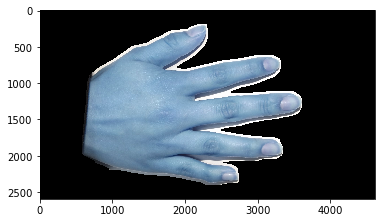

In [ ]:

plt.imshow(final)

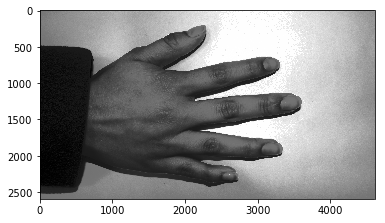

In [ ]:
# rotated = flip(final)
# plt.imshow(rotated)
plt.imshow(cv2.cvtColor(histogram_equalization(cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)), cv2.COLOR_GRAY2RGB))